In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

## Data Loading

In [3]:
df = pd.read_parquet("../data/curated/marts_downstream_houses.parquet")
df.head()

,id,price,installment,subdistrict,city,description,url,kamar_tidur,kamar_mandi,kamar_pembantu,...,hook,ruang_tamu,ruang_makan,terjangkau_internet,tags,facilities,house_materials,floor_materials,image_urls,amenities
0,hos14264153,3.190000e+09,14000000.0,Babakanmadang,Bogor,Welcome investor \nDepan Taman Yang Luas dan B...,https://www.rumah123.com/properti/bogor/hos142...,4,4,1,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, perumahan, komplek]","[ac, keamanan, taman, laundry, wastafel, ac]","[beton, bata_merah]","[keramik, ubin]",[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
1,hos15848009,1.730000e+09,7000000.0,Babakanmadang,Bogor,"Rumah Berada Di Klaster TerDepan , Dekat Denga...",https://www.rumah123.com/properti/bogor/hos158...,2,1,1,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, one_gate_system, ...","[jalur_telepon, taman, laundry, parkir, keaman...","[beton, bata_merah]",[keramik],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
2,hos15802277,4.200000e+09,19000000.0,Babakanmadang,Bogor,Beberapa alasan mengapa membeli property di ka...,https://www.rumah123.com/properti/bogor/hos158...,3,4,1,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, one_gate_system, ...","[jalur_telepon, kolam_renang, laundry, keamana...",[bata_merah],[granit],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
3,hos15998766,1.100000e+09,5000000.0,Babakanmadang,Bogor,Rumah Dijual Tipe Scandinavian Siap Huni Full ...,https://www.rumah123.com/properti/bogor/hos159...,3,1,0,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, one_gate_system, ...","[jalur_telepon, laundry, keamanan, masjid, one...",[bata_merah],[granit],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
4,hos16024616,3.250000e+09,14000000.0,Babakanmadang,Bogor,Dijual rumah dengan kolam renang dan 5 kamar t...,https://www.rumah123.com/properti/bogor/hos160...,5,5,1,...,0,1,1,1,"[bisa_nego, cash_keras, one_gate_system, perum...","[jalur_telepon, kolam_renang, taman, laundry, ...","[bata_merah, bata_hebel]",[granit],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."


In [4]:
FEATS_MONOTONE_UP = [
    "luas_tanah",
    "luas_bangunan",
    "kamar_tidur",
    "kamar_mandi",
    "jumlah_lantai",
]

FEATS = [
    'price',
    'subdistrict',
    'kamar_mandi',
    'kamar_pembantu',
    'luas_tanah',
    'luas_bangunan',
    'jumlah_lantai',
    'tahun_dibangun',
    'daya_listrik',
    'land_building_ratio',
    'total_beds',
    'total_baths',
    'building_area_floor_ratio',
    'vehicle_accessibility'
]

In [5]:
def preprocess_data(df_ori: pd.DataFrame) -> pd.DataFrame:
    # copy data
    df_data = df_ori.copy()

    # log-tranform price
    df_data["price"] = np.log(df_data["price"])

    # derive new features
    df_data["land_building_ratio"] = df_data["luas_tanah"] / df_data["luas_bangunan"]
    df_data["total_beds"] = df_data["kamar_tidur"] + df_data["kamar_pembantu"]
    df_data["total_baths"] = df_data["kamar_mandi"] + df_data["kamar_mandi_pembantu"]
    df_data["bed_bath_ratio"] = df_data["kamar_tidur"] / df_data["kamar_mandi"]
    df_data["total_bed_bath_ratio"] = df_data["total_beds"] / df_data["total_baths"]
    df_data["rennovated_built_diff"] = df_data["tahun_di_renovasi"] - df_data["tahun_dibangun"]
    df_data["building_area_floor_ratio"] = df_data["luas_bangunan"] / df_data["jumlah_lantai"]
    df_data["vehicle_accessibility"] = df_data["garasi"] + df_data["carport"] / df_data["lebar_jalan"]

    # feature selection
    df_data = df_data[FEATS]

    # convert categorical columns
    cat_cols = df_data.select_dtypes("object").columns.tolist()
    df_data = df_data.fillna(value={k: "" for k in cat_cols})
    df_data[cat_cols] = df_data[cat_cols].astype("category")

    return df_data

In [6]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=22)

In [7]:
df_train_proc = preprocess_data(df_train)
df_test_proc = preprocess_data(df_test)

X_train, y_train = df_train_proc.drop(columns=["price"]), df_train_proc["price"]
X_test, y_test = df_test_proc.drop(columns=["price"]), df_test_proc["price"]

cat_cols = X_train.select_dtypes("category").columns.tolist()
monotone_constraints = [1 if x in FEATS_MONOTONE_UP else 0 for x in X_train.columns]

## Evaluation

In [8]:
params = {
    # tuned by optuna
    "max_depth": 8,
    "reg_alpha": 1.401145940788591,
    "reg_lambda": 29.301682822072667,
    "num_leaves": 35,
    "learning_rate": 0.09502688691432662,
    "num_iterations": 392,
    "min_data_in_leaf": 36,
    "bagging_fraction": 0.9538152178075421,
    "feature_fraction": 0.7092065624236081,
    "extra_trees": False,
    "objective": "fair",

    # fixed params
    "seed": 22,
    "metric": "rmse",
    "verbosity": -1,
    "monotone_constraints": monotone_constraints,
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train, categorical_feature=cat_cols)

LGBMRegressor(bagging_fraction=0.9538152178075421, extra_trees=False,
              feature_fraction=0.7092065624236081,
              learning_rate=0.09502688691432662, max_depth=8, metric='rmse',
              min_data_in_leaf=36,
              monotone_constraints=[0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
              num_iterations=392, num_leaves=35, objective='fair',
              reg_alpha=1.401145940788591, reg_lambda=29.301682822072667,
              seed=22, verbosity=-1)

In [9]:
y_pred = model.predict(X_test)

print("R2", r2_score(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("MAPE", mean_absolute_percentage_error(y_test, y_pred))
print("sMAPE", smape(y_test, y_pred))

R2 0.9074768463135218
MAE 0.22786744184679
MSE 0.11588904108221583
MAPE 0.010887681332577642
sMAPE 0.010865832277358226


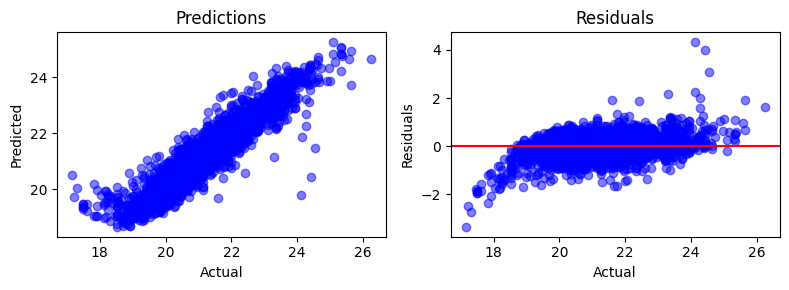

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(y_test, y_pred, color="blue", alpha=0.5)
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
ax[0].set_title("Predictions")

ax[1].scatter(y_test, y_test - y_pred, color="blue", alpha=0.5)
ax[1].axhline(y=0, color="r", linestyle="-")
ax[1].set_xlabel("Actual")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals")

fig.tight_layout()
plt.show()

In [11]:
# normality test on the residuals
stat, pvalue = sp.stats.normaltest(y_test - y_pred)
print(f"Normality test: stat={stat}, p-value={pvalue}")
print(f"Is normal? {pvalue > 0.05}")

Normality test: stat=1417.436266816515, p-value=1.612966828617869e-308
Is normal? False


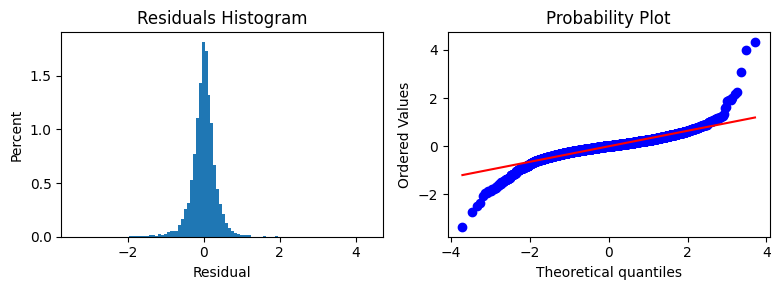

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].hist(y_test - y_pred, density=True, bins=100)
ax[0].set_xlabel("Residual")
ax[0].set_ylabel("Percent")
ax[0].set_title("Residuals Histogram")

sp.stats.probplot(y_test - y_pred, dist="norm", plot=ax[1])

fig.tight_layout()
plt.show()

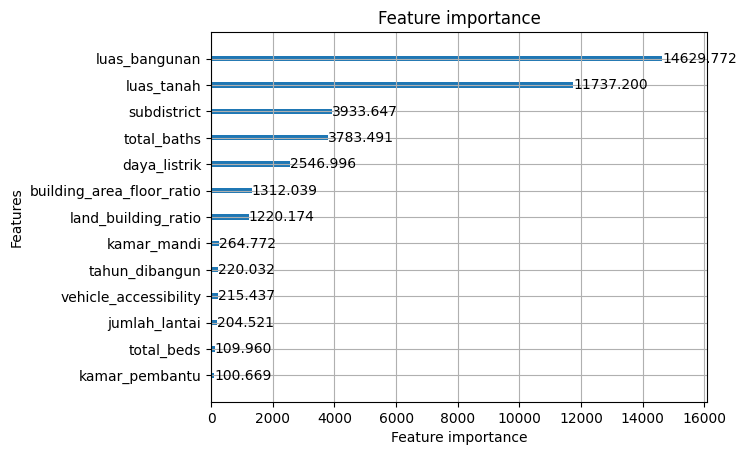

In [13]:
fig, ax = plt.subplots()
lgb.plot_importance(model, importance_type="gain", ax=ax)
plt.show()

<Axes: >

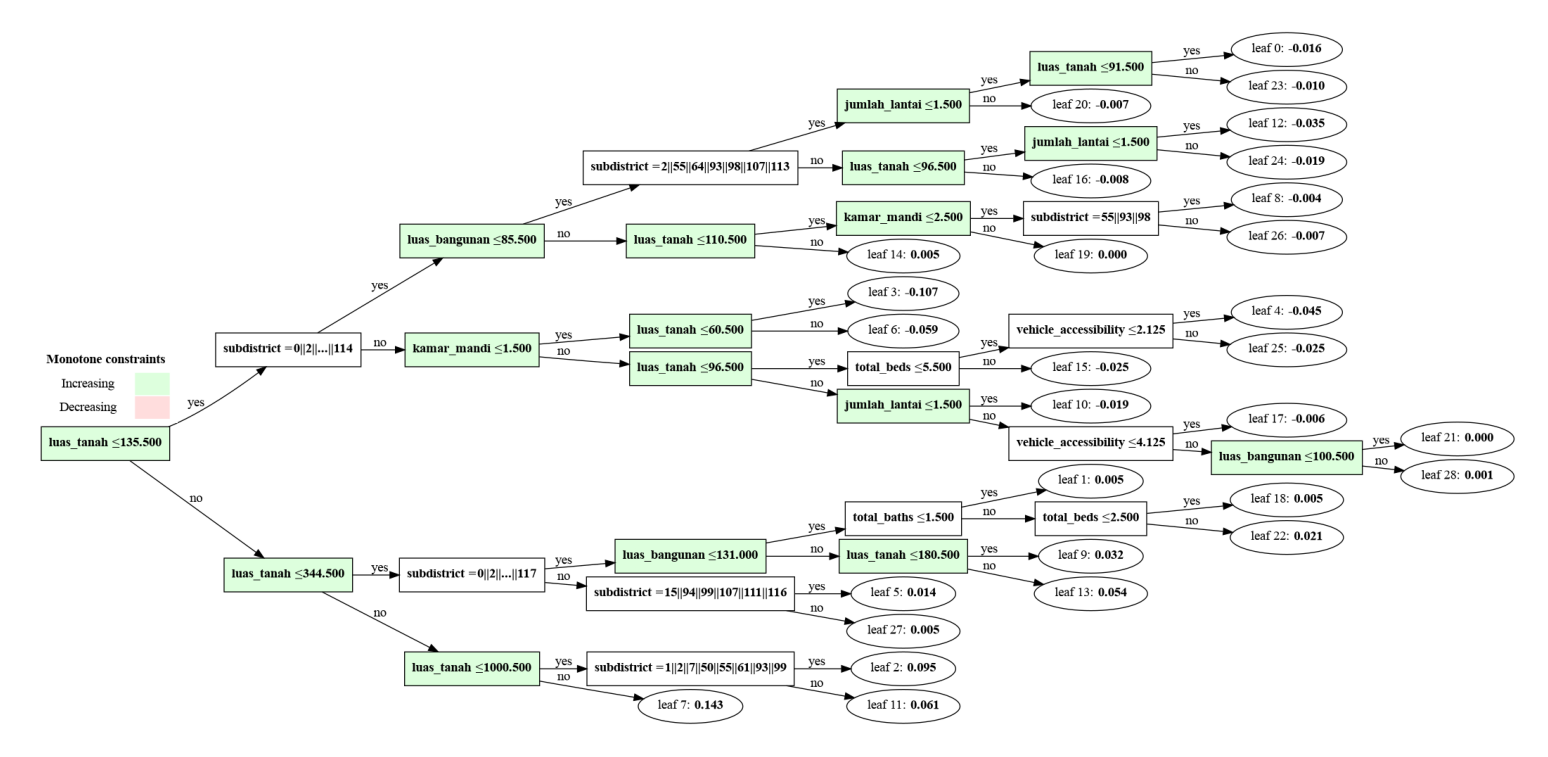

In [14]:
lgb.plot_tree(model, tree_index=5, dpi=300)

## SHAP

In [15]:
import shap

/home/fahmi/projects/project-rumah-regresi/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

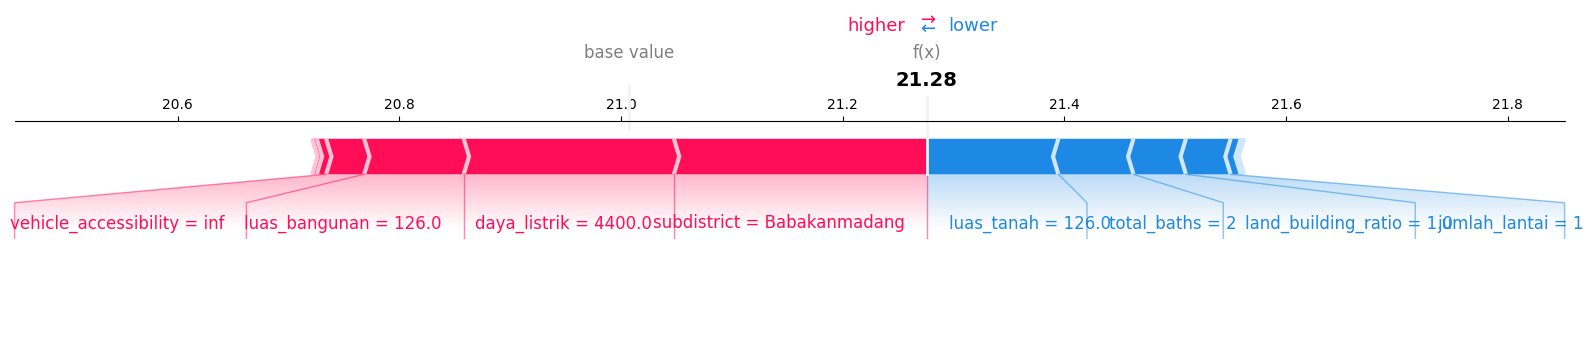

In [17]:
shap.force_plot(shap_values[0], matplotlib=True)

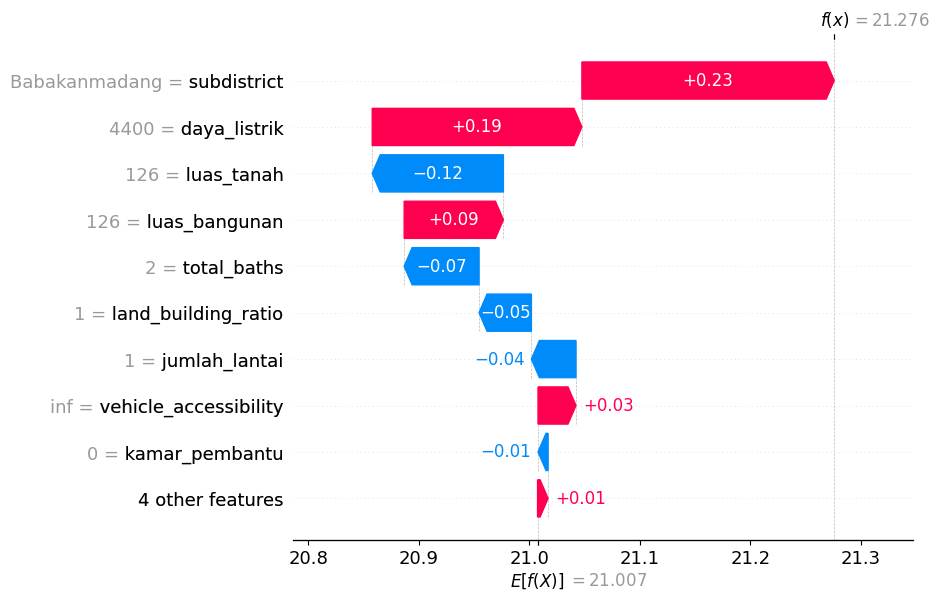

In [18]:
shap.waterfall_plot(shap_values[0])

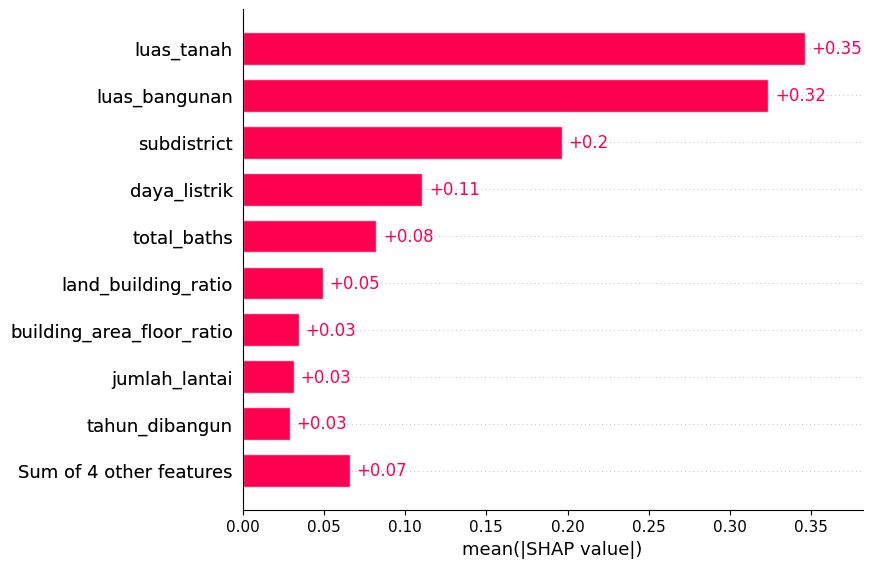

In [19]:
shap.plots.bar(shap_values)

/home/fahmi/projects/project-rumah-regresi/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


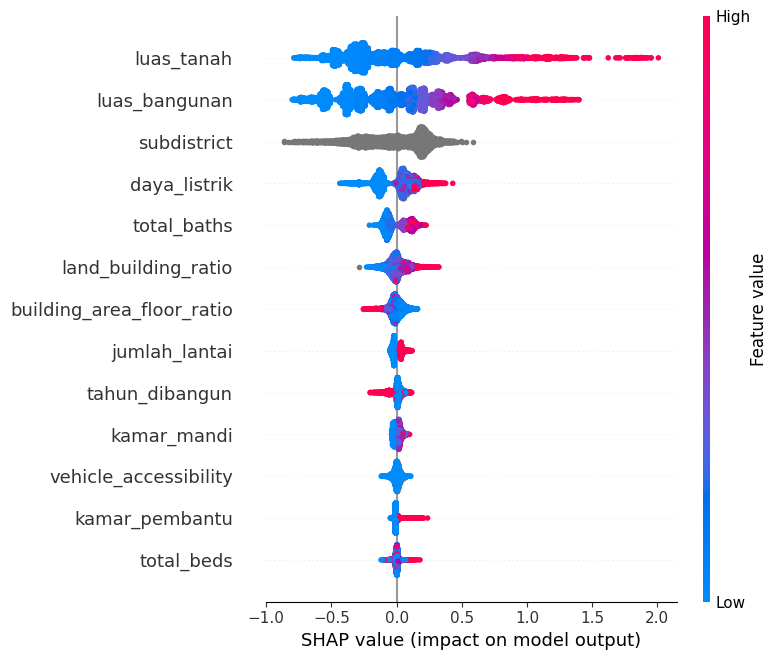

In [20]:
shap.summary_plot(shap_values, X_test)

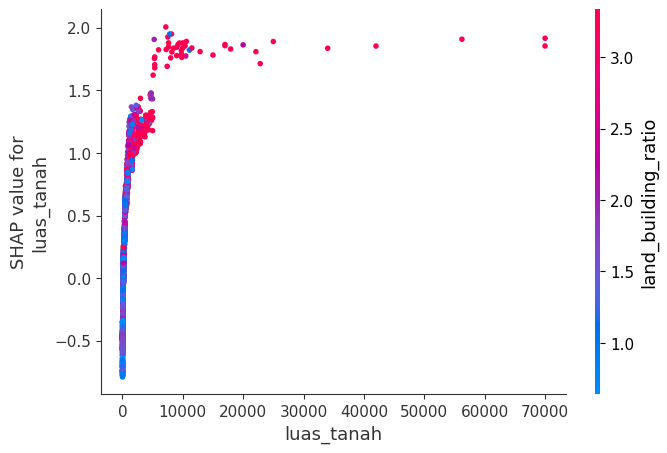

In [21]:
shap.dependence_plot("luas_tanah", shap_values.values, X_test, display_features=X_test)

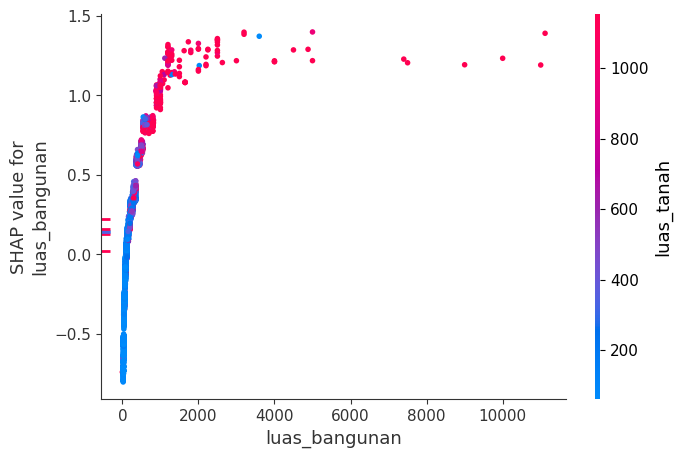

In [22]:
shap.dependence_plot("luas_bangunan", shap_values.values, X_test, display_features=X_test)